 ## References 

 * Data source: https://www.unsw.adfa.edu.au/unsw-canberra-cyber/cybersecurity/ADFA-NB15-Datasets/
 * Sample/starter code: https://github.com/Nir-J/ML-Projects/blob/master/UNSW-Network_Packet_Classification/unsw.py

In [0]:
%config IPCompleter.greedy=True
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib as matplot
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.filterwarnings("ignore")

from keras.models import Model, load_model
from keras.layers import *
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,normalize

# Preprocessing (transformation/scaling) 

In [0]:
train = pd.read_csv('https://raw.githubusercontent.com/Nir-J/ML-Projects/master/UNSW-Network_Packet_Classification/UNSW_NB15_training-set.csv')
test = pd.read_csv('https://raw.githubusercontent.com/Nir-J/ML-Projects/master/UNSW-Network_Packet_Classification/UNSW_NB15_testing-set.csv')
combined_data = pd.concat([train, test]).drop(['id'],axis=1)

In [125]:
tmp = train.where(train['attack_cat'] == "Normal").dropna()
len(tmp['attack_cat'])/len(train['attack_cat'])
print ()
tmp = test.where(test['attack_cat'] == "Normal").dropna()
len(tmp['attack_cat'])/len(test['attack_cat'])

0.3193776697977085

0.44939999028324346

In [126]:
le1 = LabelEncoder()
le = LabelEncoder()

vector = combined_data['attack_cat']

print("attack cat:", set(list(vector))) # use print to make it print on single line 

combined_data['attack_cat'] = le1.fit_transform(vector)
combined_data['proto'] = le.fit_transform(combined_data['proto'])
combined_data['service'] = le.fit_transform(combined_data['service'])
combined_data['state'] = le.fit_transform(combined_data['state'])

vector = combined_data['attack_cat']
print('\nDescribing attack_type: ')
print("min", vector.min())
print("max", vector.max())
print("mode",vector.mode())
print("mode", len(np.where(vector.values==6)[0])/len(vector),"%")
print("looks like 6 is 'normal', but its not that common") 

attack cat: {'Worms', 'Backdoor', 'DoS', 'Reconnaissance', 'Fuzzers', 'Normal', 'Generic', 'Shellcode', 'Analysis', 'Exploits'}

Describing attack_type: 
min 0
max 9
mode 0    6
dtype: int64
mode 0.3609225646458884 %
looks like 6 is 'normal', but its not that common


In [127]:
le1.inverse_transform([0,1,2,3,4,5,6,7,8,9])

array(['Analysis', 'Backdoor', 'DoS', 'Exploits', 'Fuzzers', 'Generic',
       'Normal', 'Reconnaissance', 'Shellcode', 'Worms'], dtype=object)

In [128]:
# lowSTD = list(combined_data.std().to_frame().nsmallest(6,columns=0).index)
# lowCORR = list(combined_data.corr().abs().sort_values('attack_cat')['attack_cat'].nsmallest(3).index) # .where(lambda x: x < 0.005).dropna()
# drop = set( lowCORR + lowSTD)
drop = {'ackdat', 'ct_ftp_cmd', 'djit', 'is_ftp_login', 'is_sm_ips_ports', 'response_body_len', 'sjit', 'synack', 'tcprtt'}
combined_data.shape
combined_data_reduced=combined_data.drop(drop,axis=1)
combined_data_reduced.shape

(257673, 44)

(257673, 35)

In [0]:
transform = list(combined_data_reduced.columns.values[4:])
transform.append('dur')
transform.remove('attack_cat')
# transform min-max norm 
combined_data_reduced[transform] = combined_data_reduced[transform].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

In [0]:
data_x = combined_data_reduced.drop(['attack_cat','label'], axis=1) # droped label
data_y = combined_data_reduced.loc[:,['label']]
# del combined_data # free mem
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=.90, random_state=42) # TODO

In [0]:
#combined_data_reduced.where(combined_data_reduced['label'] == 1.0).dropna().tail(20)

In [132]:
X_train.shape
y_train.shape
X_test.shape # test is larger... good 
y_test.shape

(25767, 33)

(25767, 1)

(231906, 33)

(231906, 1)

# Benchmark before additional feature removal

In [0]:
# x = X_train
# y = y_train['attack_cat'].ravel()

DTC = DecisionTreeClassifier() 
RFC = RandomForestClassifier(n_estimators=25, random_state=1)
ETC = ExtraTreesClassifier(n_estimators=10, criterion='gini', max_features='auto', bootstrap=False)

# eclf = VotingClassifier(estimators=[('lr', DTC), ('rf', RFC),('et',ETC)], voting='hard') 
# for clf, label in zip([DTC, RFC,ETC, eclf], ['DecisionTreeClassifier', 'RandomForestClassifier', 'ExtraTreesClassifier', 'Ensemble']): 
#     _ = eclf.fit(X_train,y_train)
#     pred = eclf.score(X_test,y_test)
#     print("Acc: %0.10f [%s]" % (pred,label))

0.82 will all data and on reduced data

In [0]:
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA,TruncatedSVD,PCA
from sklearn.svm import LinearSVC
n = 10 

In [0]:
rfe = RFE(DecisionTreeClassifier(), n).fit(X_train,y_train)

desiredIndices = np.where(rfe.support_==True)[0]
whitelist = X_train.columns.values[desiredIndices]
X_train_RFE,X_test_RFE = X_train[whitelist],X_test[whitelist]

# eclf = VotingClassifier(estimators=[('DecisionTreeClassifier', DTC), ('RandomForestClassifier', RFC),('ExtraTreesClassifier',ETC)], voting='hard')
# _ = eclf.fit(X_train_RFE,y_train)
# pred = eclf.score(X_test_RFE,y_test)

# print("Acc: %0.10f" % (pred))
# print("number of features",X_train_RFE.shape[1])

In [0]:
svd = TruncatedSVD(n_components=n-1).fit(X_train_RFE)   # -20 will give 0.778, in the below benchmark preditings catogories 
X_train_svd, X_test_svd = svd.transform(X_train_RFE), svd.transform(X_test_RFE)

# Benchmark after additional feature removal

In [137]:
print(X_train_svd.shape)

DTC = DecisionTreeClassifier() 
RFC = RandomForestClassifier(n_estimators=25, random_state=1)
ETC = ExtraTreesClassifier(n_estimators=10, criterion='gini', max_features='auto', bootstrap=False)

# eclf = VotingClassifier(estimators=[('DecisionTreeClassifier', DTC), ('RandomForestClassifier', RFC),('ExtraTreesClassifier',ETC)], voting='hard')
# for clf, label in zip([DTC, RFC,ETC, eclf], ['DecisionTreeClassifier', 'RandomForestClassifier', 'ExtraTreesClassifier', 'Ensemble']): 
#     _ = eclf.fit(X_train_svd,y_train)
#     pred = eclf.score(X_test_svd,y_test)
#     print("Acc: %0.10f [%s]" % (pred,label))

(25767, 9)


 **predicting *label*:** 
```
RFE only 
Acc: 0.9259010116 [DecisionTreeClassifier]
Acc: 0.9258389175 [RandomForestClassifier]
Acc: 0.9255957155 [ExtraTreesClassifier]
Acc: 0.9259010116 [Ensemble]
number of features 20
---------------
Acc: 0.9386820522
number of features 10
[ pipeing to SVD 9 dimentions yeilds:  Acc: 0.9221753642 [Ensemble] ; piping to PCA will yeild .921] 
```
```
(64418, 20)
* Acc: 0.9283589040 [DecisionTreeClassifier]
* Acc: 0.9278052314 [RandomForestClassifier]
* Acc: 0.9286848982 [ExtraTreesClassifier]
* Acc: 0.9278000569 [Ensemble]
```
```
(64418, 10)
Acc: 0.9141341751 [DecisionTreeClassifier]
Acc: 0.9145119143 [RandomForestClassifier]
Acc: 0.9141290005 [ExtraTreesClassifier]
Acc: 0.9135028848 [Ensemble]
```




# Lets' try another way

In [0]:
# from sklearn.model_selection import cross_val_score
# from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.linear_model import RidgeClassifier
# from sklearn.svm import SVC
# seed = 1075
# np.random.seed(seed)
# # Create classifiers
# rf = RandomForestClassifier()
# et = ExtraTreesClassifier()
# knn = KNeighborsClassifier()
# svc = SVC()
# rg = RidgeClassifier()

In [0]:
# clf_array = [rf, et, knn, svc, rg]
# for clf in clf_array:
#     vanilla_scores = cross_val_score(clf, X_train_RFE, y_train, cv=3, n_jobs=-1)
#     bagging_clf = BaggingClassifier(clf, 
#        max_samples=0.4, max_features=10, random_state=seed)
#     bagging_scores = cross_val_score(bagging_clf, X_test, y_test, cv=3, 
#        n_jobs=-1)
    
#     print("Mean of: {1:.3f}, std: (+/-) {2:.3f} [{0}]".format(clf.__class__.__name__,vanilla_scores.mean(), vanilla_scores.std()))
#     print("Mean of: {1:.3f}, std: (+/-) {2:.3f} [Bagging {0}]\n".format(clf.__class__.__name__,bagging_scores.mean(), bagging_scores.std()))

# Onto Deep Learning 
> I ran SVD/PCA to remove variance since my goal to "get the better deep learning result possible" 

In [0]:
from keras.models import Sequential


```
Notes: 

sigmoid for binary 

Softmax = non-binary 

```


In [166]:
X = X_train_svd
X_t = X_test_svd

dim = X.shape[1]
dim

9

In [0]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
# X_train_svd = mms.fit_transform(X_train_svd)
# X_test_svd = mms.transform(X_test_svd)

In [0]:
classifier = Sequential()
#First Hidden Layer
classifier.add(Dense(18, activation='relu', input_dim=dim))

classifier.add(Dense(36, activation='relu'))

classifier.add(Dense(18, activation='relu' ))

classifier.add(Dense(9, activation='relu'))

classifier.add(Dense(1, activation='sigmoid'))

classifier.compile(optimizer ='adam',loss='binary_crossentropy', metrics =['accuracy'])

In [193]:
tensorboard = TensorBoard(histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = classifier.fit(X,y_train, batch_size=16, epochs=100, validation_data=(X_t,y_test) , callbacks=[tensorboard]).history

Train on 25767 samples, validate on 231906 samples
Epoch 1/100
25767/25767 [==============================] - 16s 602us/step - loss: 0.1500 - acc: 0.9298 - val_loss: 0.1668 - val_acc: 0.9243
Epoch 2/100
25767/25767 [==============================] - 16s 611us/step - loss: 0.1504 - acc: 0.9288 - val_loss: 0.1641 - val_acc: 0.9238
Epoch 3/100
25767/25767 [==============================] - 16s 606us/step - loss: 0.1520 - acc: 0.9296 - val_loss: 0.1701 - val_acc: 0.9240
Epoch 4/100
25767/25767 [==============================] - 16s 615us/step - loss: 0.1496 - acc: 0.9306 - val_loss: 0.1678 - val_acc: 0.9207
Epoch 5/100
25767/25767 [==============================] - 16s 603us/step - loss: 0.1504 - acc: 0.9296 - val_loss: 0.1710 - val_acc: 0.9228
Epoch 6/100
25767/25767 [==============================] - 16s 604us/step - loss: 0.1510 - acc: 0.9301 - val_loss: 0.1846 - val_acc: 0.9181
Epoch 7/100
25767/25767 [==============================] - 16s 605us/step - loss: 0.1502 - acc: 0.9286 - val_

In [194]:
#!pip install keras_sequential_ascii
from keras_sequential_ascii import keras2ascii
keras2ascii(classifier)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####           9
               Dense   XXXXX -------------------       180    10.5%
                relu   #####          18
               Dense   XXXXX -------------------       684    40.0%
                relu   #####          36
               Dense   XXXXX -------------------       666    38.9%
                relu   #####          18
               Dense   XXXXX -------------------       171    10.0%
                relu   #####           9
               Dense   XXXXX -------------------        10     0.6%
             sigmoid   #####           1


In [199]:
eval_model=classifier.evaluate(X, y_train)
print(eval_model)

eval_model=classifier.evaluate(X_t, y_test)
print(eval_model)


predictions=classifier.predict(X_t)
predictions =(predictions>0.80)

mse = np.mean(np.power(X_test_svd - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,'true_class': y_test.values.reshape(1,-1)[0]})
# error_df.describe()
print()
print(np.mean(mse))
cm = confusion_matrix(y_test, y_pred)
print(cm)

25767/25767 [==============================] - 1s 25us/step
[0.1386234540349611, 0.9340241394031125]
231906/231906 [==============================] - 6s 25us/step
[0.16736483896156854, 0.9242408562089812]

0.568583993218773
[[ 60296  23338]
 [  2941 145331]]


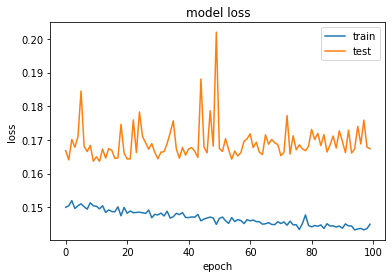

In [196]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

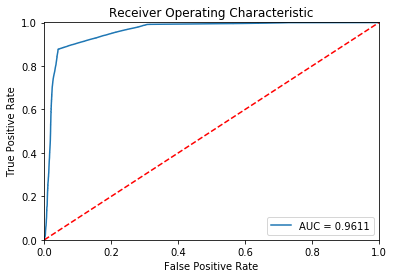

In [197]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error,pos_label=1)
roc_auc = auc(fpr, tpr)


plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

Text(0.5, 1.0, 'Recall vs Precision')

Text(0.5, 0, 'Recall')

Text(0, 0.5, 'Precision')

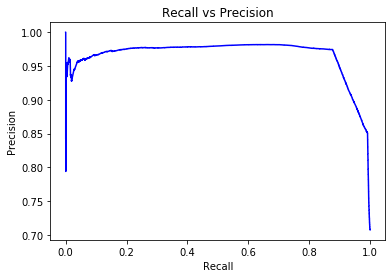

In [198]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error,pos_label=1)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()